# A simple K-means clustering of flow citometry data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Data import from .csv file

In [2]:
flow_data = pd.read_csv('C:/Adatok/data science/flow clustering/flow_export.csv', header=1)

*The data used in this analysis consists of 35125 instances, each representing a single measured cell. Fluorescence intensity was recorded along several channels, however, only the markers IgD and CD27 are used for the actual clustering.*<br>
<br>
*In addition, this dataset has been preprocessed in FlowJo. Flow cytometry gating strategy included time gates in which flow stability was checked (y:FSC-A/x:time, y:SSC-A/x:time). Doublet discrimination was performed based on forward scatter height and area (y:FSC-H/x:FSC-A). Lymphocyte population was identified in a side scatter/forward scatter area (y:SSC-A/x:FSC-A) gate. B cells were gated by CD19 positivity. Finally, channel values containing the raw data of this B cell population were exported as a .csv file to work with.*

In [3]:
flow_selection = flow_data.copy()
flow_selection = flow_selection[['FJComp-APC-A', 'FJComp-PE-A']]   # to select the right channels to work with
flow_selection.rename(columns={'FJComp-APC-A':'IgD', 'FJComp-PE-A':'CD27'}, inplace=True)   # to rename channels by the markers

In [4]:
flow_selection.head()

,IgD,CD27
0,417,304
1,739,506
2,709,267
3,666,355
4,236,526


### Data scaling

In flow citometry different channels record fluorescent marker intesnity in different ranges which phenomenon is defined by the actual sensor-marker combination. These alterations might not represent biological differences, therefore it is necessary to scale the data.<br>
The sklearn StandardScaler() function transforms the data to set scales with a zero mean and unit variance.

In [5]:
scaler = StandardScaler()
flow_mod = scaler.fit_transform(flow_selection)

In [6]:
flow_mod

array([[-0.1369767 , -0.37449753],
       [ 1.42631168,  1.04917795],
       [ 1.2806637 , -0.63526977],
       ...,
       [-1.04970407, -0.68460506],
       [ 1.31464823, -0.19830007],
       [ 1.82927111, -0.5225034 ]])

### Finding the optimal number of clusters

K-means clustering requires the number of clusters as an input.<br>
Examining inertia and the silhouette score with different number of clusters helps to find an ideal scenario.

In [7]:
# function to calculate inertia and to plot the results
def cluster_number_iner(data, max_k):
    cluster_list = []
    inertia_list = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
        kmeans.fit(data)
        
        cluster_list.append(k)
        inertia_list.append(kmeans.inertia_)
    
    # for the elbow plot
    plt.figure(figsize=(8, 4))
    plt.plot(cluster_list, inertia_list, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

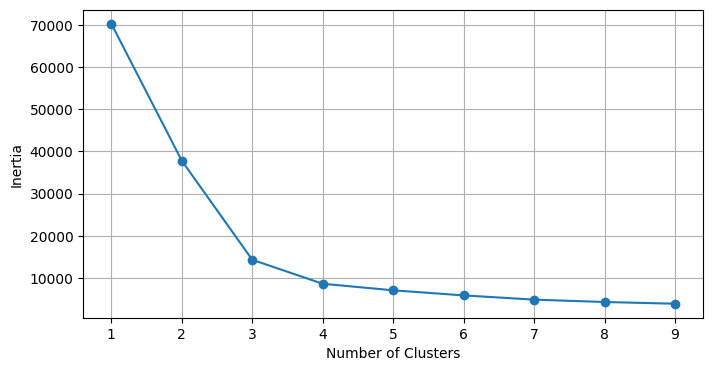

In [8]:
# to plot inertia up until 9 clusters
cluster_number_iner(flow_mod, 10)

In [9]:
# function to calculate the silhouette score and to plot the results
def cluster_number_silh(data, max_k):
    cluster_list = []
    silh_score_list = []
   
    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
        kmeans.fit(data)
        label=kmeans.predict(data)
        silh_score = silhouette_score(data, label)
       
        cluster_list.append(k)
        silh_score_list.append(silh_score)
   
    # for the plot
    plt.figure(figsize=(8, 4))
    plt.plot(cluster_list, silh_score_list, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

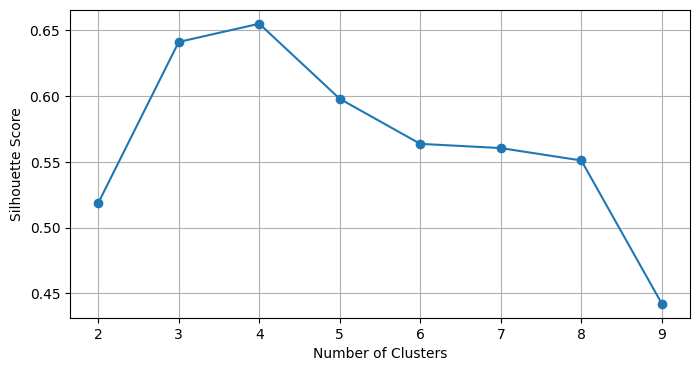

In [10]:
# to plot the silhouette score up until 9 clusters
cluster_number_silh(flow_mod, 10)

### K-means clustering

Based on the graphs presented above, 4 clusters would be an optimal choice for this analysis. However, it can be useful to assess cluster numbers slightly below and above the optimal to see how well clusters align with the data in these situations. Therefore, cluster numbers 3 through 5 were tested.

In [11]:
# K-means clustering with 3, 4 and 5 clusters
for k in range(3, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
    kmeans.fit(flow_mod)
    flow_selection[f'kmeans_c{k}'] = kmeans.labels_

### Plotting the results of clustering

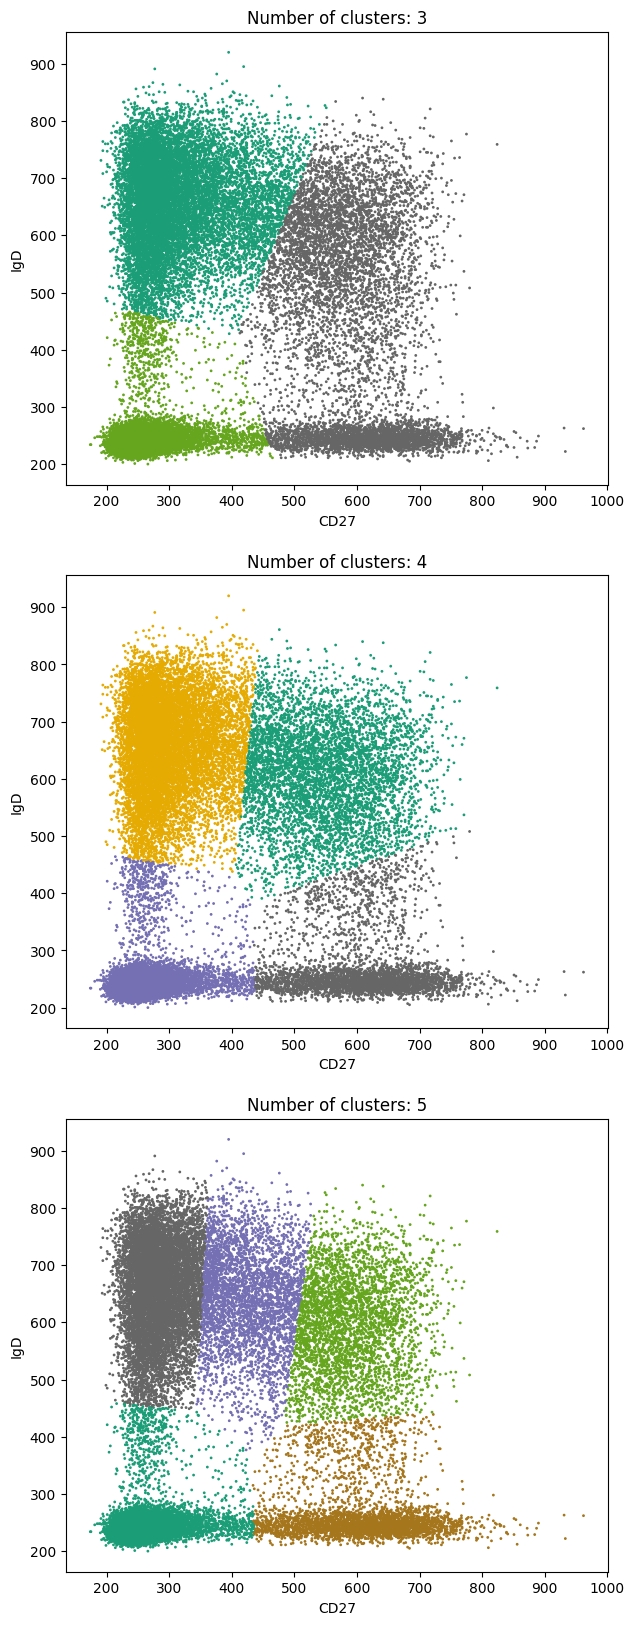

In [12]:
# plots
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,20))

for i, ax in enumerate(fig.axes, start=3):
    ax.scatter(x=flow_selection['CD27'], y=flow_selection['IgD'], c=flow_selection[f'kmeans_c{i}'], s=1, cmap='Dark2')
    ax.set_xlabel('CD27')
    ax.set_ylabel('IgD')
    ax.set_title(f'Number of clusters: {i}')

#### Focusing on four clusters

In [13]:
# to get the centroids of the clusters
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10)
kmeans.fit(flow_mod)
centroids = kmeans.cluster_centers_

In [14]:
# separation of the clusters
cluster_0 = flow_selection[flow_selection['kmeans_c4'] == 0]
cluster_1 = flow_selection[flow_selection['kmeans_c4'] == 1]
cluster_2 = flow_selection[flow_selection['kmeans_c4'] == 2]
cluster_3 = flow_selection[flow_selection['kmeans_c4'] == 3]

In [15]:
# custom color map for the plot
color_list = ['#1B9E77', '#E7298A', '#7570B3', '#E6AB02']
custom_cmap = cls.ListedColormap(color_list)

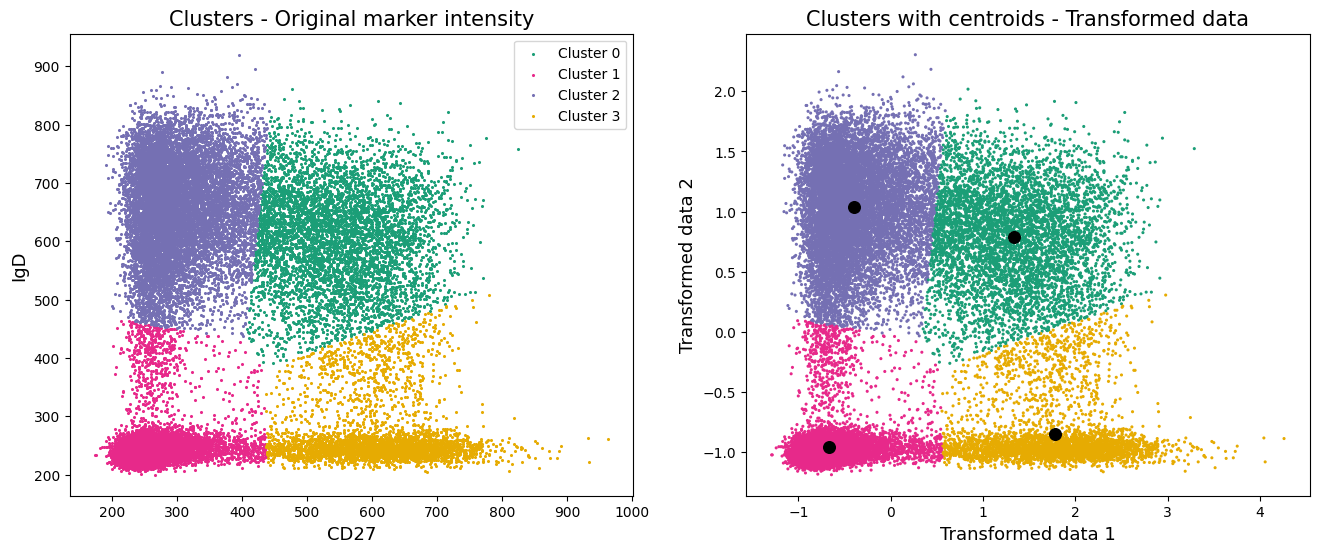

In [16]:
# plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].scatter(x=cluster_0['CD27'], y=cluster_0['IgD'], s=1.5, label='Cluster 0', c='#1B9E77')
ax[0].scatter(x=cluster_1['CD27'], y=cluster_1['IgD'], s=1.5, label='Cluster 1', c='#E7298A')
ax[0].scatter(x=cluster_2['CD27'], y=cluster_2['IgD'], s=1.5, label='Cluster 2', c='#7570B3')
ax[0].scatter(x=cluster_3['CD27'], y=cluster_3['IgD'], s=1.5, label='Cluster 3', c='#E6AB02')
ax[0].set_title('Clusters - Original marker intensity', fontsize=15)
ax[0].set_xlabel('CD27', fontsize=13)
ax[0].set_ylabel('IgD', fontsize=13)
ax[0].legend()

ax[1].scatter(x=flow_mod[:,1], y=flow_mod[:,0], c=flow_selection['kmeans_c4'], s=1.5, cmap=custom_cmap)
ax[1].scatter(x=centroids[:,1], y=centroids[:,0], c='black', s=70)
ax[1].set_title('Clusters with centroids - Transformed data', fontsize=15)
ax[1].set_xlabel('Transformed data 1', fontsize=13)
ax[1].set_ylabel('Transformed data 2', fontsize=13)

plt.savefig('kmeans_clusters.jpg', bbox_inches='tight', dpi=200)

#### Heatmaps to represent marker intensity in the four clusters

In [17]:
# to calculate mean and median marker intensity for the clusters
cluster_means = flow_selection[['IgD', 'CD27', 'kmeans_c4']].groupby('kmeans_c4').mean()
cluster_medians = flow_selection[['IgD', 'CD27', 'kmeans_c4']].groupby('kmeans_c4').median()

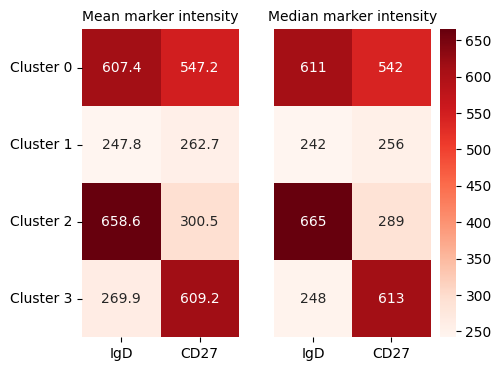

In [18]:
# plots
fontdict={'fontsize':10.}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,4), width_ratios=(1,1.25))

sns.heatmap(cluster_means, cmap='Reds', annot=True, fmt='.1f', cbar=False, ax=ax[0])
ax[0].set_yticks([0.5, 1.5, 2.5, 3.5], ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], rotation=0)
ax[0].set_title('Mean marker intensity', **fontdict)
ax[0].set_ylabel('')

sns.heatmap(cluster_medians, cmap='Reds', annot=True, fmt='.0f', yticklabels=False, ax=ax[1])
ax[1].set_title('Median marker intensity', **fontdict)
ax[1].set_ylabel('')

plt.savefig('kmeans_heatmaps.jpg', bbox_inches='tight', dpi=200)